# VariationalAutoEncoderの実装

In [2]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連 p
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cloudpickle

from utils import try_gpu

## モデル構築

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        # side_size: 画像の1辺サイズ
        # output_size: 出力サイズ
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4_mu = nn.Linear(32, output_size)
        self.fc4_var = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # 分散は非負値の前提
        return self.fc4_mu(x), F.softplus(self.fc4_var(x))

Encoder(28*28, 2)

Encoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4_mu): Linear(in_features=32, out_features=2, bias=True)
  (fc4_var): Linear(in_features=32, out_features=2, bias=True)
)

In [4]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

Decoder(2, 28*28)

Decoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
)

In [10]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, inout_size, latent_size):
        # inout_size:inとoutのサイズ
        # latent_size:潜在空間の次元数
        super(VariationalAutoEncoder, self).__init__()
        self.inout_size = inout_size
        self.latent_size = latent_size
        self.encoder = Encoder(inout_size, latent_size)
        self.decoder = Decoder(latent_size, inout_size)
        
    def forward(self, x):
        x = x.view(-1, 784)
        mu, var = self.encoder(x)
        z = self.reparameterize(mu, var)
        x_hat = self.decoder(z)
        return x_hat, mu, var
    
    def reparameterize(self, mu, var):
        epsilon = torch.randn(mu.shape)
        epsilon = try_gpu(epsilon)
        return mu + epsilon * torch.sqrt(var)
    
    def loss(self, x_hat, x, mu, var):
        # reconstruction loss：入力画像をどのくらい正確に復元できたか？
        # 数式では対数尤度の最大化だが, 交差エントロピーlossの最小化と等価
        recon = F.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
        # 正則化項：q(z|x)が p(z)~N(0, I) に近くなるようにする
        # 正規分布の KL Divergence
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kld = -0.5 * torch.sum(1 + torch.log(var) - mu**2 - var)
        return recon + kld
    
    def forward_calculate_loss(self, data):
        # 1batch における loss 計算
        # data_loader から渡される mini_batch から loss を計算
        imgs, _ = data
        x = try_gpu(Variable(imgs))
        x_hat, mu, var = self(x)
        return self.loss(x_hat, x, mu, var)

In [11]:
from utils import init_model
model = init_model(VariationalAutoEncoder, inout_size=28*28, latent_size=2)
model

VariationalAutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4_mu): Linear(in_features=32, out_features=2, bias=True)
    (fc4_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=784, bias=True)
  )
)

## 学習

In [7]:
from utils import make_dataset_loader, run_train_test

In [12]:
# train settings
model_name = 'vae'
num_epochs = 100
batch_size = 256
learning_rate = 1e-3
model = init_model(VariationalAutoEncoder, inout_size=28*28, latent_size=2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# data download
task_name = 'mnist'
load_func = torchvision.datasets.MNIST
train_dataset_loader, test_dataset_loader = make_dataset_loader(batch_size, load_func)

loaded <class 'torchvision.datasets.mnist.MNIST'> train:60000, test:10000


In [13]:
trained_dict = run_train_test(model, model_name, task_name, optimizer, num_epochs, train_dataset_loader, test_dataset_loader)

make dir ./runs/mnist/vae/20191106T173421, ./models/mnist/vae/20191106T173421
epoch [1/100], step:235, loss:234.0914, test_loss:190.9913, {'elapsed': '8秒', 'remain': '13分37秒'}
model save to ./models/mnist/vae/20191106T173421/epoch001.pt
epoch [2/100], step:470, loss:186.2062, test_loss:177.3103, {'elapsed': '15秒', 'remain': '12分18秒'}
model save to ./models/mnist/vae/20191106T173421/epoch002.pt
epoch [3/100], step:705, loss:173.5386, test_loss:170.1581, {'elapsed': '21秒', 'remain': '11分48秒'}
model save to ./models/mnist/vae/20191106T173421/epoch003.pt
epoch [4/100], step:940, loss:167.8893, test_loss:166.6596, {'elapsed': '28秒', 'remain': '11分28秒'}
model save to ./models/mnist/vae/20191106T173421/epoch004.pt
epoch [5/100], step:1175, loss:164.9887, test_loss:164.2699, {'elapsed': '35秒', 'remain': '11分17秒'}
model save to ./models/mnist/vae/20191106T173421/epoch005.pt
epoch [6/100], step:1410, loss:162.1404, test_loss:160.9868, {'elapsed': '42秒', 'remain': '11分5秒'}
model save to ./models/

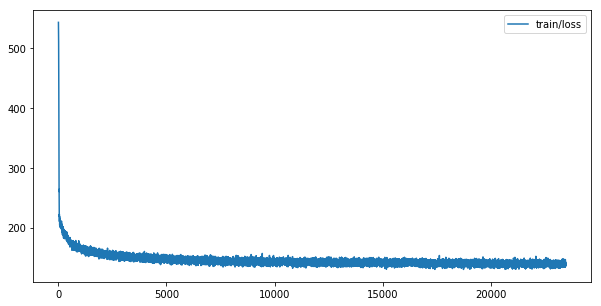

In [14]:
from utils import extract_scalar_from_event, plot_from_dict

scalar_dict = extract_scalar_from_event(trained_dict['log_dir'])
plt.figure(figsize=(10, 5))
plot_from_dict(scalar_dict, 'train/loss')

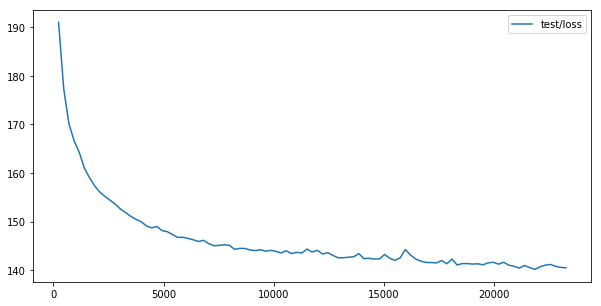

In [15]:
plt.figure(figsize=(10, 5))
plot_from_dict(scalar_dict, 'test/loss')

## デコード出力描画

epochごとの学習具合を確認

In [16]:
from utils import load_model, plot_gray_img

In [26]:
def output_shaped(model, imgs):
    # modelからのAEの出力を描画用にreshapeして出力
    size = int(np.sqrt(model.inout_size))
    output, mu, var  = model(try_gpu(imgs.view(-1, size*size)))
    return output.view(-1, 1, size, size).cpu().data

In [27]:
from glob import glob
model_path_list = glob(f'{trained_dict["model_dir"]}/*.pt')
model_path_list = sorted(model_path_list)

In [28]:
model = load_model(model_path_list[-1])

In [29]:
model

VariationalAutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4_mu): Linear(in_features=32, out_features=2, bias=True)
    (fc4_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=784, bias=True)
  )
)

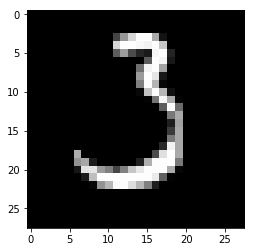

In [30]:
_imgs, _labels = iter(test_dataset_loader).next()
_input_img = _imgs[0].view(28, 28)
plot_gray_img(_input_img)

CPU times: user 22 ms, sys: 148 µs, total: 22.1 ms
Wall time: 19.3 ms


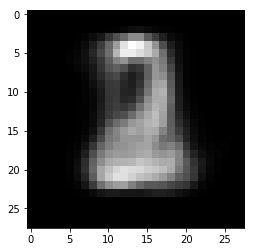

In [31]:
%%time
_output_img = output_shaped(model, _input_img).view(28, 28)
plot_gray_img(_output_img)

In [34]:
import os
from utils import plot_img_grid

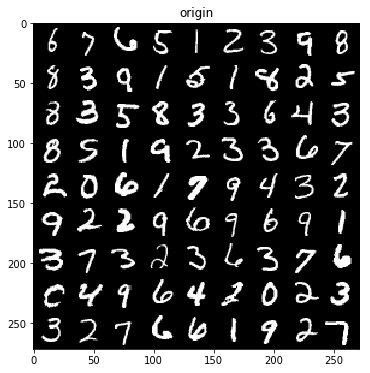

In [36]:
_input_imgs = iter(test_dataset_loader).next()[0][:9*9]
decode_dir = f'./decode/{task_name}/{model_name}'
os.makedirs(decode_dir, exist_ok=True)
plot_img_grid(_input_imgs, 9, f'{decode_dir}/origin.png', 'origin')

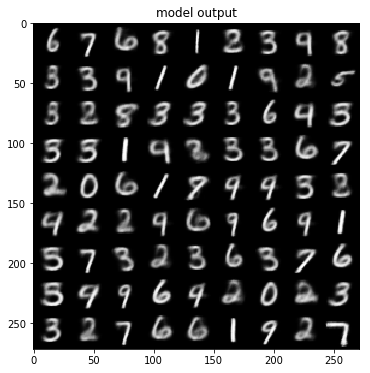

In [37]:
# 最後のモデルの出力
latest_model_output = output_shaped(model, _input_imgs)
plot_img_grid(latest_model_output, 9, title='model output')

一気に出力

In [ ]:
import re
import os
from tqdm import tqdm
for model_path in tqdm(model_path_list):
    model = load_model(model_path)
    output = output_shaped(model, _input_imgs)
    epoch = re.sub("\\D", "", os.path.basename(model_path))
    plot_img_grid(output, title=f'epoch: {epoch}', save_path=f'./decode/{task_name}/{model_name}/epoch{epoch}.png', nrow=9)

Gifにする

In [41]:
from PIL import Image, ImageDraw
git_output_path = f'./decode/{task_name}/{model_name}/model_outputs.gif'
images = [Image.open(img_path) for img_path in sorted(glob(f'./decode/{task_name}/{model_name}/*.png'))]
images[0].save(git_output_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
git_output_path

'./decode/mnist/vae/model_outputs.gif'

## 潜在空間の分布

せっかく2次元まで圧縮したので分布を確認する

In [42]:
model = load_model(model_path_list[-1])

In [43]:
from tqdm import tqdm
label_xy_list = [[] for _ in range(10)]
for img, label in tqdm(test_dataset_loader.dataset):
    mu, var = model.encoder(try_gpu(img.view(-1, 28*28)))
    mu = mu.data.cpu().numpy()[0]
    var = var.data.cpu().numpy()[0]
    label_xy_list[label].append([mu, var])

100%|██████████| 10000/10000 [00:08<00:00, 1144.98it/s]


In [50]:
xy_arr = np.array(label_xy_list[0])

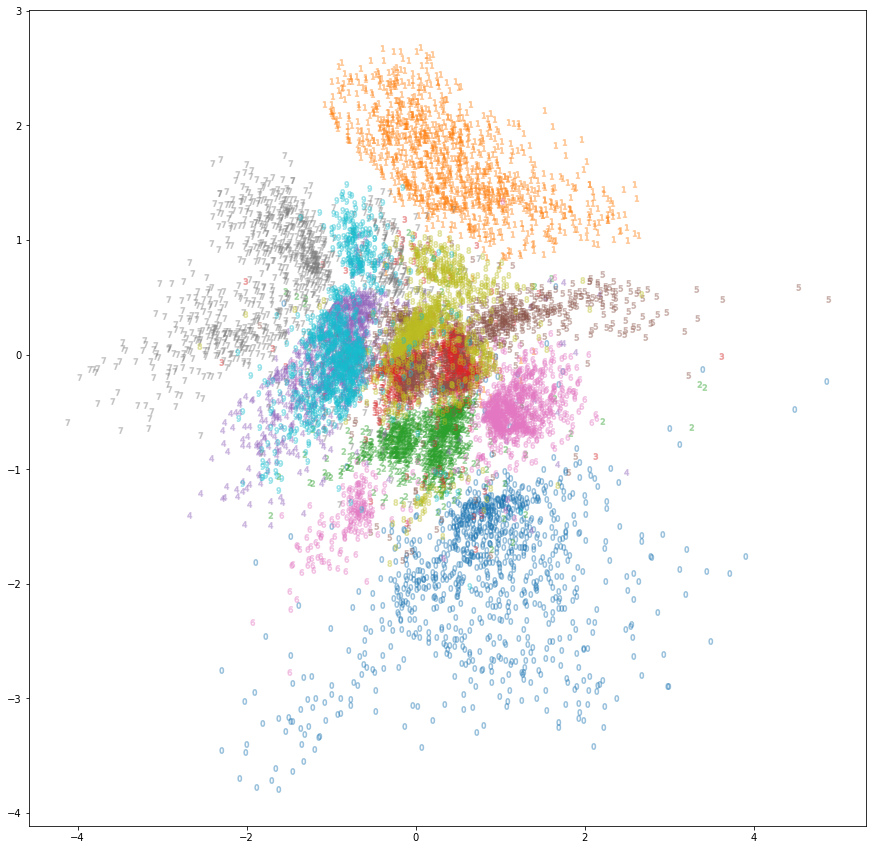

In [60]:
def plot_encoded_space(ax=None):
    if ax is None:
        ax = plt
        ax.figure(figsize=(15, 15))
    for label in range(10):
        xy_arr = np.array(label_xy_list[label])
        ax.plot(xy_arr[:,0,0], xy_arr[:,0,1], '.', marker="${}$".format(label), label=label, alpha=0.3)

plot_encoded_space()

## 潜在空間を指定して生成

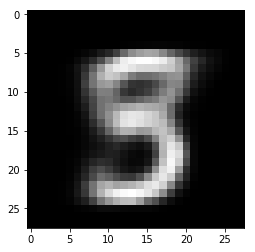

In [61]:
model = load_model(model_path_list[-1])
output = model.decoder((try_gpu(torch.tensor([0, 0]).float()))).view(1, 784)
plot_gray_img(output.view(28, 28).cpu().data)

In [62]:
import itertools
xy_list = list(itertools.product(np.arange(-4, 4, 0.2), np.arange(-4, 4, 0.2)))
xy_list = sorted(xy_list, key=lambda x: x[1], reverse=True)
xy_list = try_gpu(torch.tensor(xy_list, dtype=torch.float))

In [65]:
# 40*40の画像をまとめてplot
import math
outputs = model.decoder(xy_list)
output_imgs = outputs.view(-1, 1, 28, 28)
nrow = int(math.sqrt(output_imgs.size(0)))
imgs = torchvision.utils.make_grid(output_imgs, nrow=nrow, normalize=True)[0]
nrow

40

In [66]:
output_imgs.shape

torch.Size([1600, 1, 28, 28])

CPU times: user 2.56 s, sys: 279 ms, total: 2.84 s
Wall time: 2.36 s


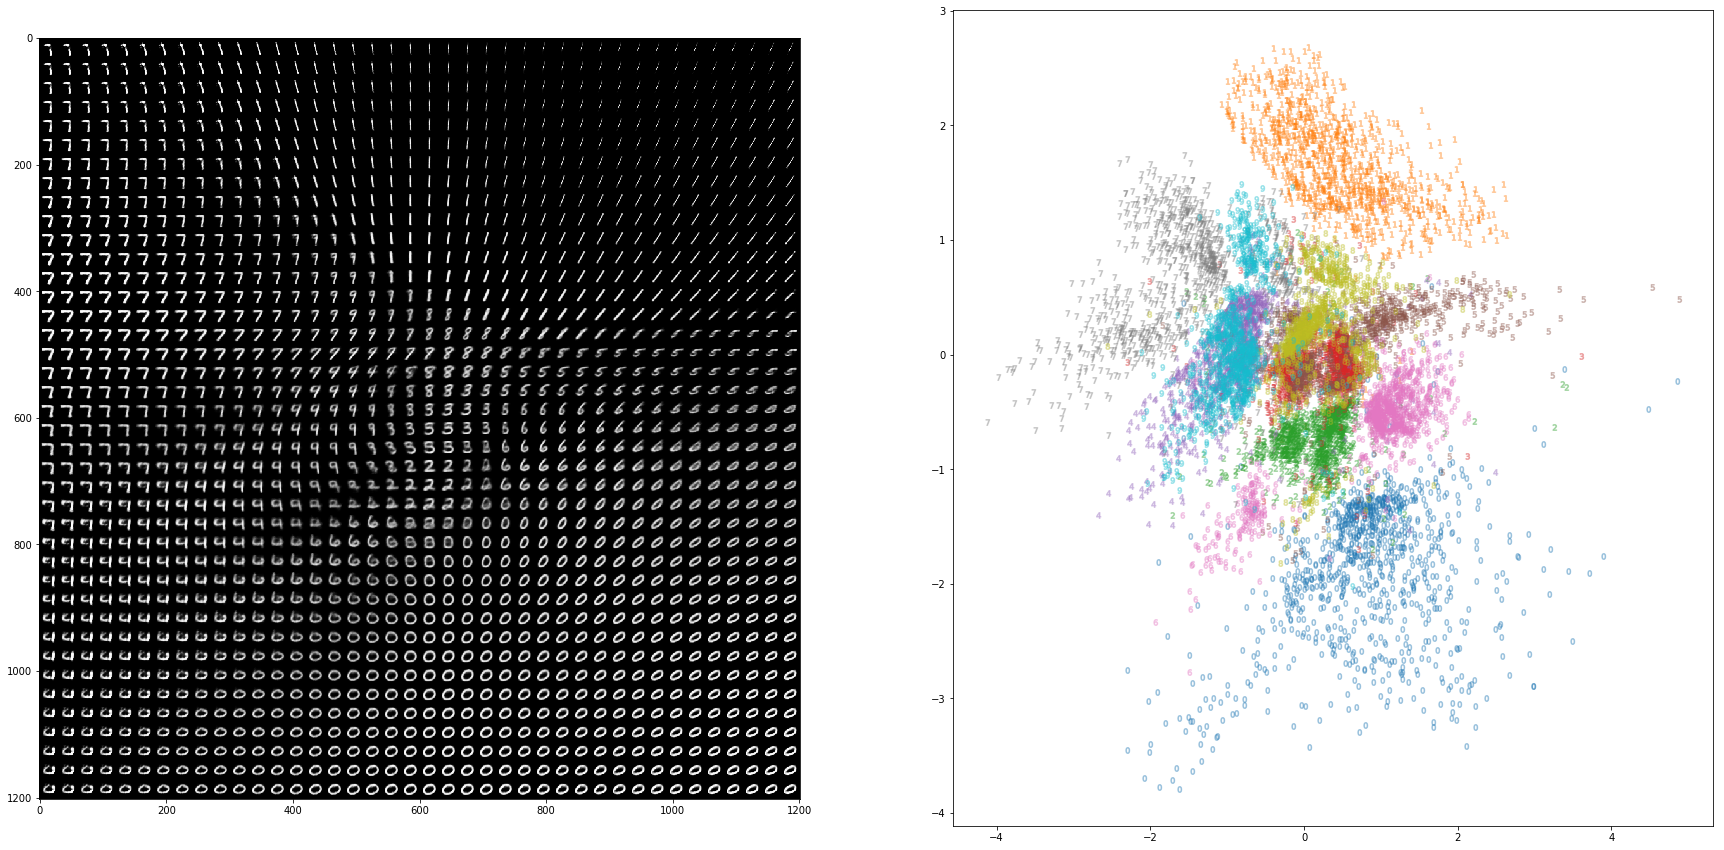

In [67]:
%%time
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plot_gray_img(imgs.cpu().data, ax1)
plot_encoded_space(ax2)
plt.savefig(f'./decode/{task_name}/{model_name}/model_output_dist.png', dpi=150)